In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from bigdatavqa.coreset import Coreset

import cudaq

from bigdatavqa.divisiveclustering import (
    DivisiveClusteringKMeans,
    DivisiveClusteringMaxCut,
    DivisiveClusteringRandom,
    DivisiveClusteringVQA

)

from bigdatavqa.optimizer import get_optimizer_for_VQE

from bigdatavqa.vqe_utils import get_VQE_circuit, get_K2_Hamiltonian

from bigdatavqa.plot import Voironi_Tessalation, Dendrogram
import warnings

warnings.filterwarnings('ignore')

In [2]:
number_of_qubits = 10
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_coresets_to_evaluate = 15
number_of_sampling_for_centroids = 20
threshold_for_max_cut = 0.7

## Coresets
The next step is to create coreset from the raw data. 

In [3]:
raw_data = Coreset.create_dataset(1000)

coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

Using BFL2 method to generate coresets


In [4]:
coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df['weights'] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,6.622686,0.164968,94.880779,A
1,10.502512,-1.577412,16.642301,B
2,4.605368,2.140070,32.335480,C
3,-1.220166,1.956169,69.062773,D
4,8.071200,-0.165519,72.624625,E
5,0.632128,-0.137690,167.462849,F
6,-0.107979,-0.707216,110.080569,G
7,4.108650,3.193422,17.828703,H
8,6.100960,1.590576,104.568167,I
9,0.065748,-0.566267,122.372030,J


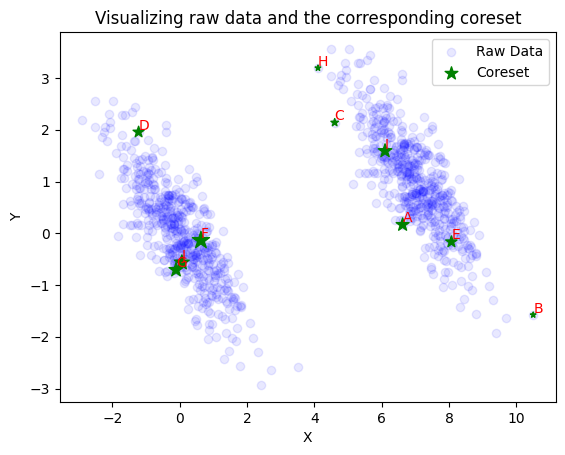

In [5]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color = 'blue', alpha=0.09, label = "Raw Data")
plt.scatter(coreset_df.X, coreset_df.Y, s = coreset_df.weights, marker='*', color = 'green', label = "Coreset")
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy = (row.X, row.Y+ 0.05), color = "red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE execution

In [13]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer_for_VQE,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence_VQE = divisive_clustering.get_divisive_sequence(coreset_df)

VQE_cost = sum(divisive_clustering.get_divisive_cluster_cost(hierarchial_clustering_sequence_VQE, coreset_df))

print(f"cost: {VQE_cost}")


100%|██████████| 2/2 [00:00<00:00, 3892.63it/s]

cost: 115.44563969063935


### Exploring results

#### Dendrogram

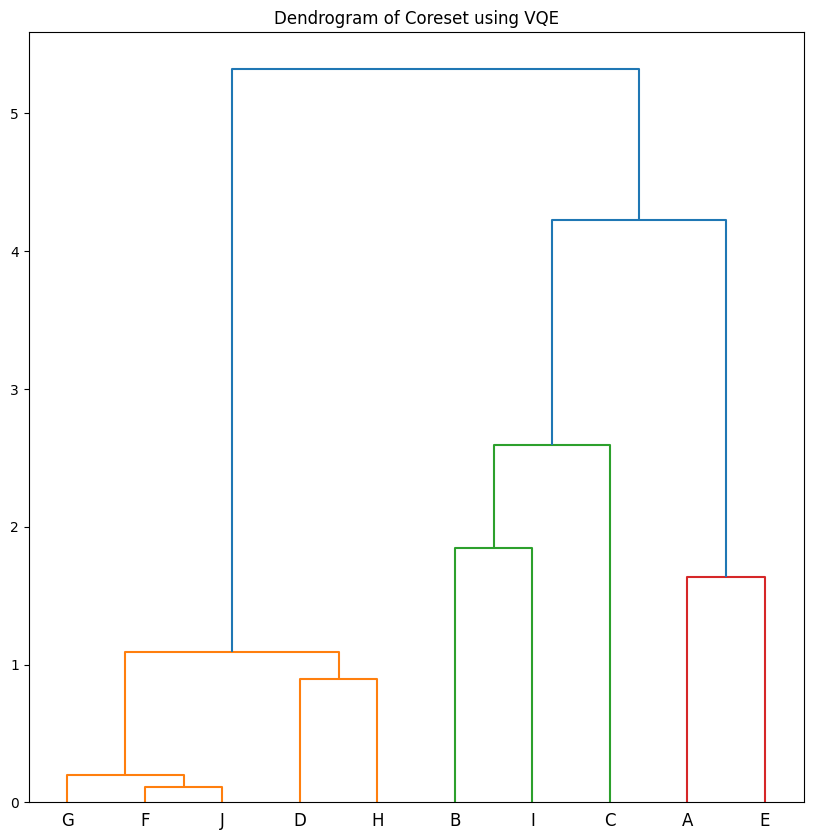

In [14]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_VQE)
dendo.plot_dendrogram(plot_title="Dendrogram of Coreset using VQE")

#### Viewing the split at each iteration

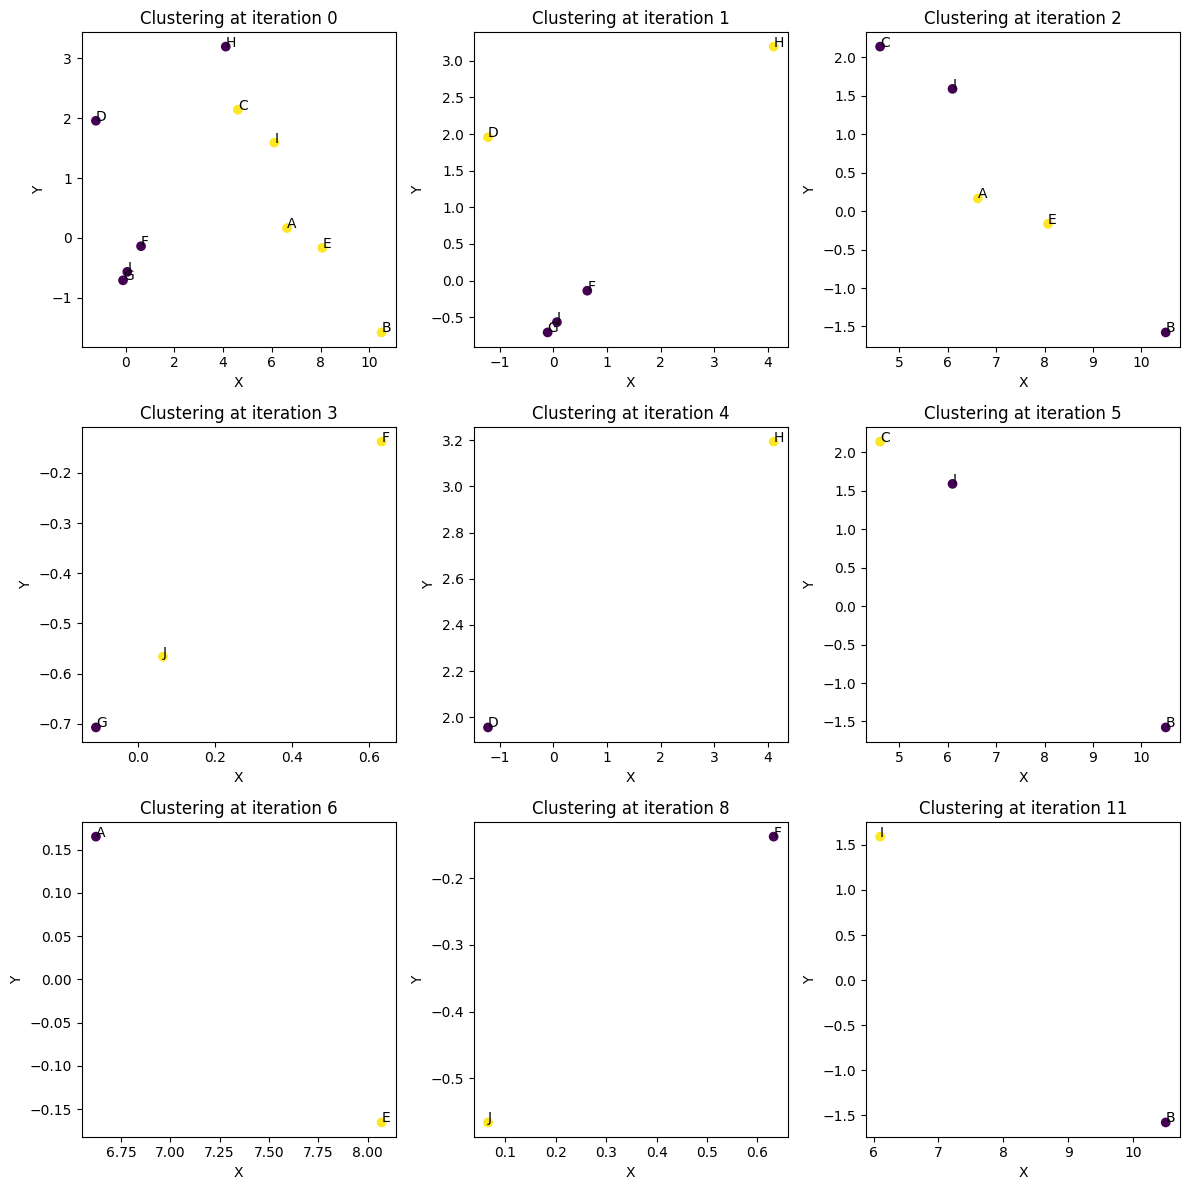

In [15]:
Dendrogram.plot_hierarchial_split(hierarchial_clustering_sequence_VQE, coreset_df)

#### Converting Hierarchical Clustering to Flat Clustering

In [78]:
clusters = dendo.get_clusters_using_height(threshold=2)
print(f"Clusters from height: {clusters}")

Clusters from height: [0 2 0 0 1 3 1 3 3 3]


In [62]:
clusters = dendo.get_clusters_using_k(k=4)
print(f"Clusters from k: {clusters}")

Clusters from k: [0 0 1 1 0 0 0 0 0 1]


### Voronoi Tessellation

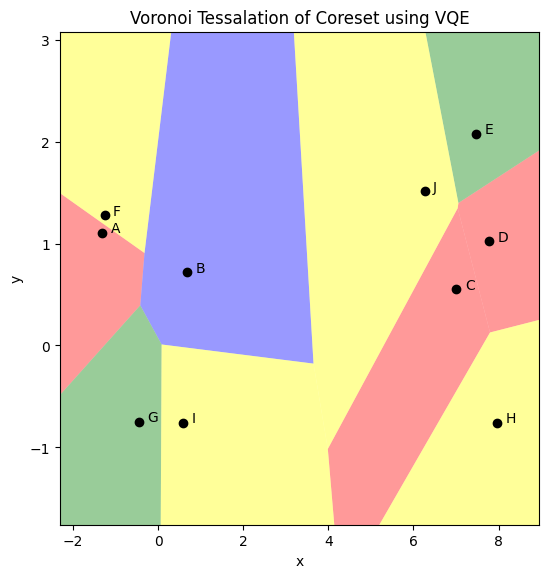

In [80]:
colors = ["red", "green", "blue", "yellow", "purple", "black"]
vt = Voironi_Tessalation(coreset_df, clusters, colors)
vt.plot_voironi(plot_title="Voronoi Tessalation of Coreset using VQE", show_annotation=True, show_scatters=True)

## Random clustering

cost: 352.30427491848684


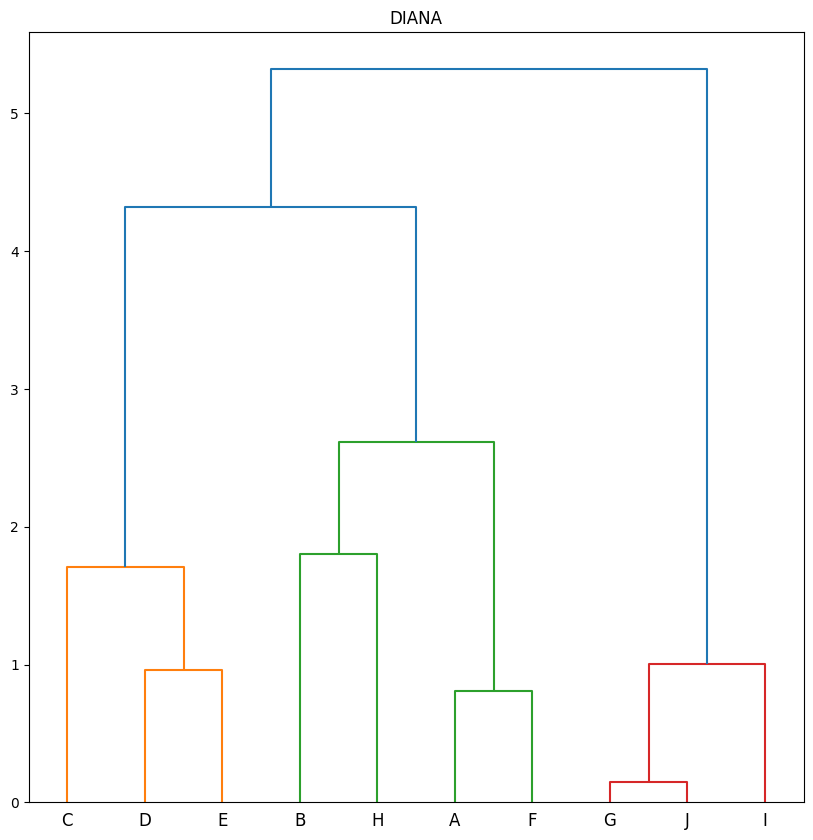

In [22]:
divisive_clustering = DivisiveClusteringRandom()

hierarchial_clustering_sequence_random = divisive_clustering.get_divisive_sequence(coreset_df)

random_cost = sum(divisive_clustering.get_divisive_cluster_cost(hierarchial_clustering_sequence_random, coreset_df))

print(f"cost: {random_cost}")

dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_random)
dendo.plot_dendrogram()

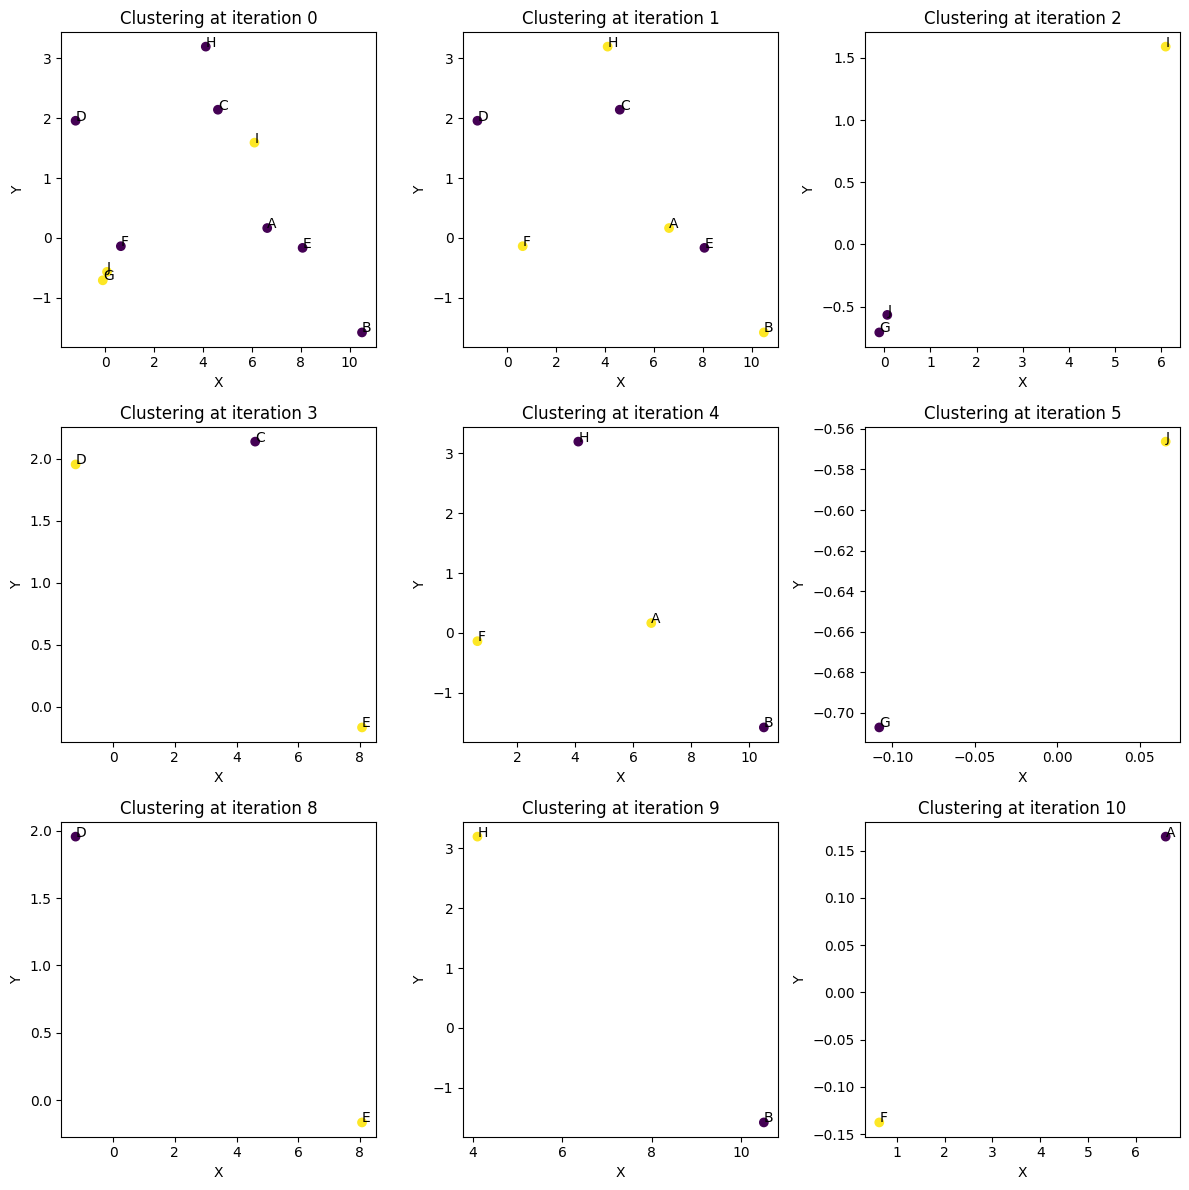

In [23]:
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_random, coreset_df)

### KMeans clustering

cost: 64.44566137544199


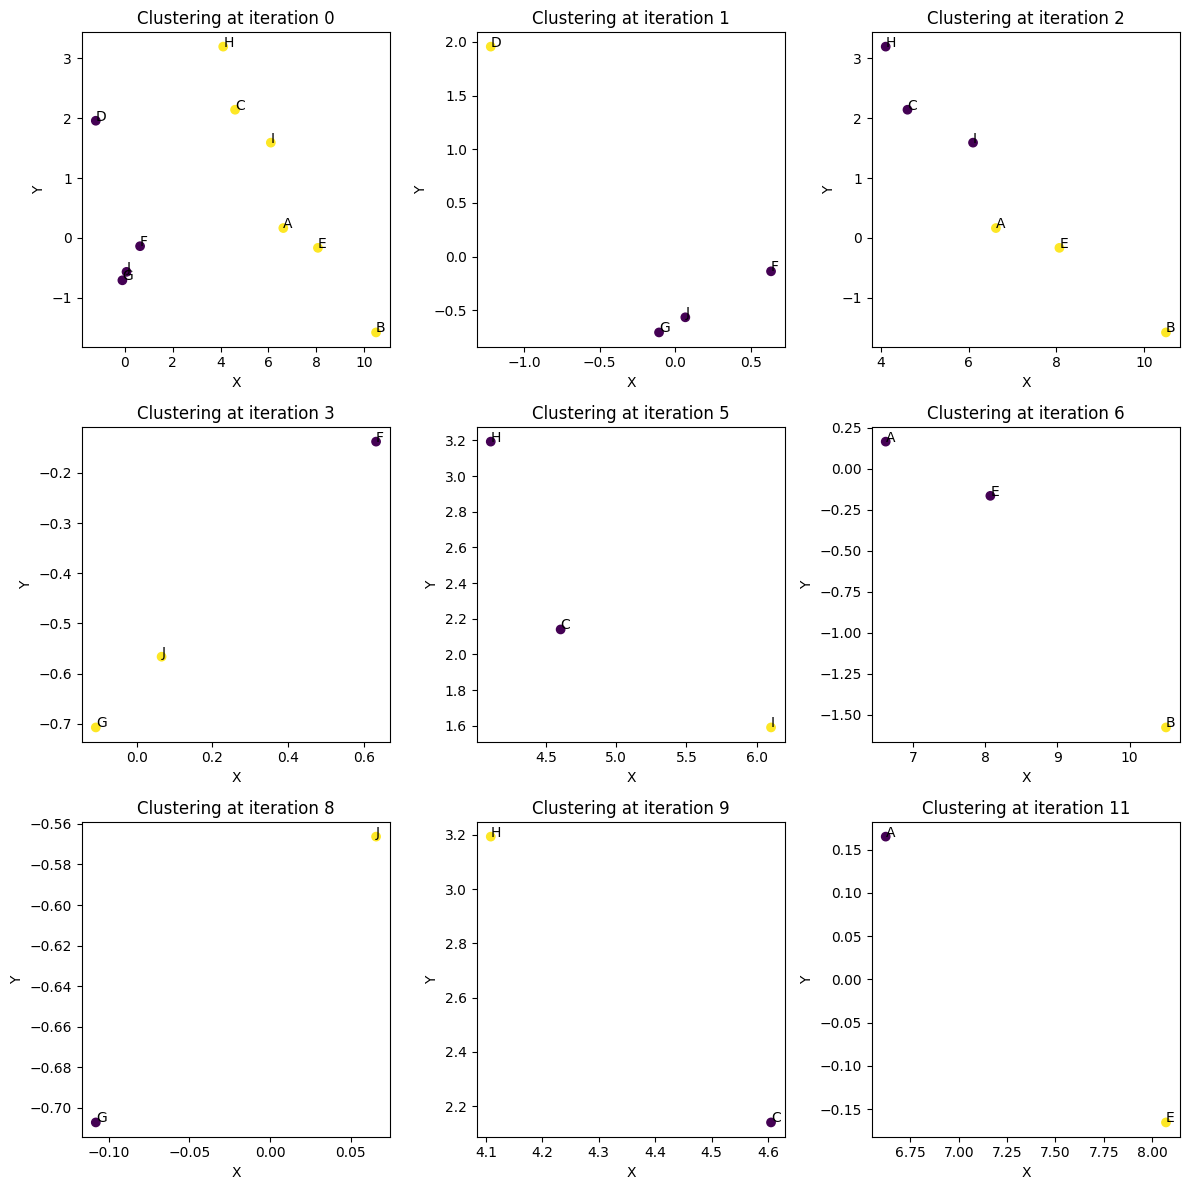

In [25]:
divisive_clustering = DivisiveClusteringKMeans()

hierarchial_clustering_sequence_KMeans = divisive_clustering.get_divisive_sequence(coreset_df)

KMeans_cost = sum(divisive_clustering.get_divisive_cluster_cost(hierarchial_clustering_sequence_KMeans, coreset_df))

print(f"cost: {KMeans_cost}")

dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_KMeans)
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_KMeans, coreset_df)

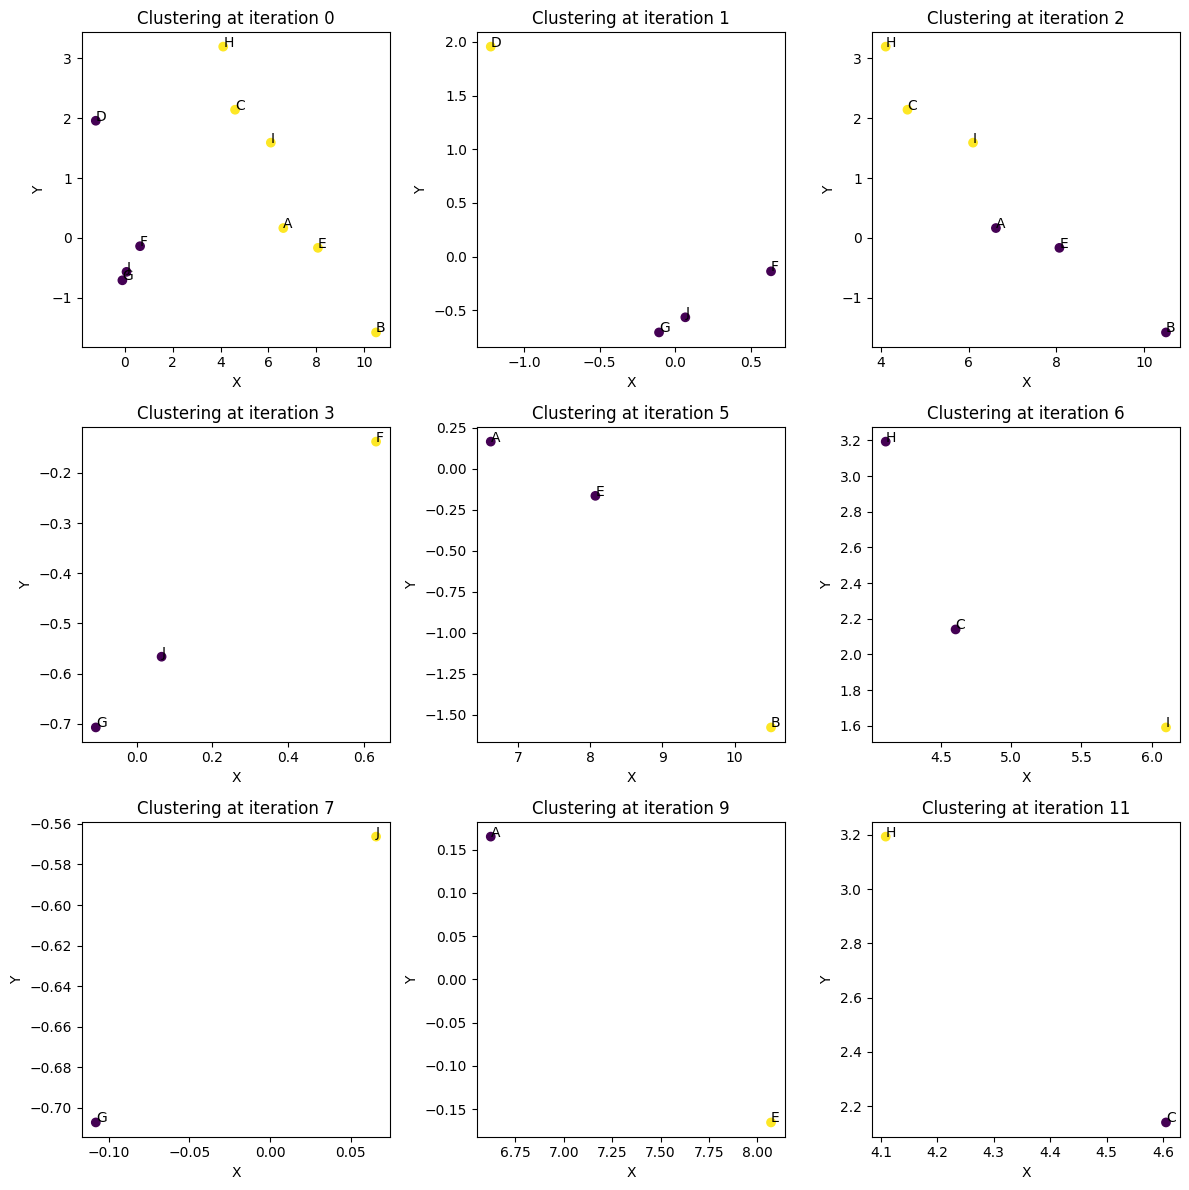

In [18]:
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_KMeans, coreset_df)

### MaxCut

  0%|          | 0/1022 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 33332.22it/s]


cost: 377.86890108965895


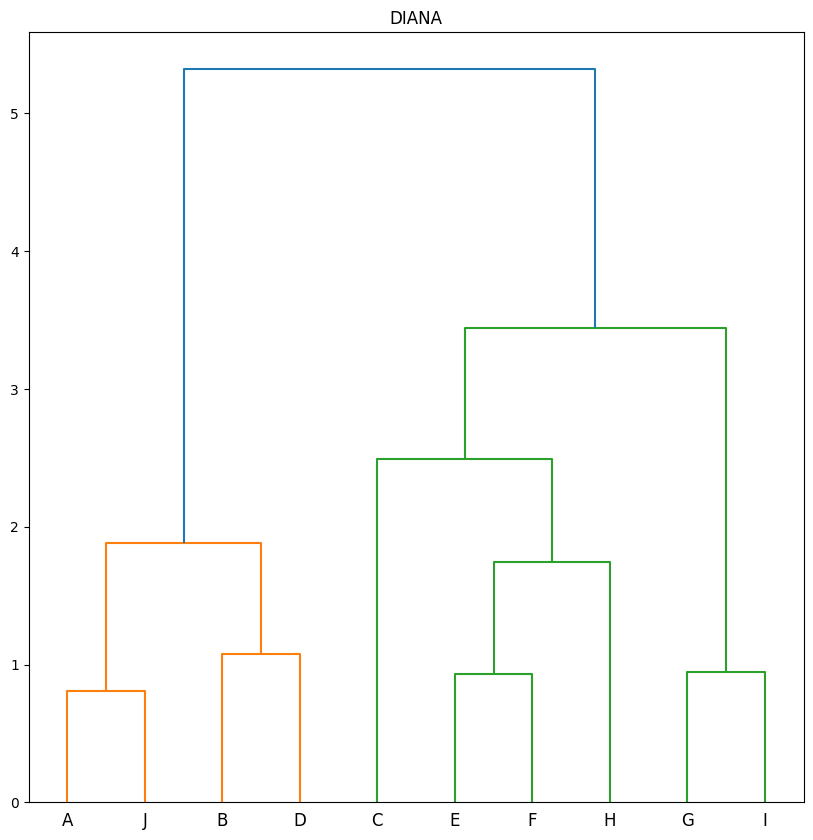

In [19]:
divisive_clustering = DivisiveClusteringMaxCut()

hierarchial_clustering_sequence_MaxCut = divisive_clustering.get_divisive_sequence(coreset_df)

MaxCut_cost = sum(divisive_clustering.get_divisive_cluster_cost(hierarchial_clustering_sequence_MaxCut, coreset_df))

print(f"cost: {MaxCut_cost}")

dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_MaxCut)
dendo.plot_dendrogram()

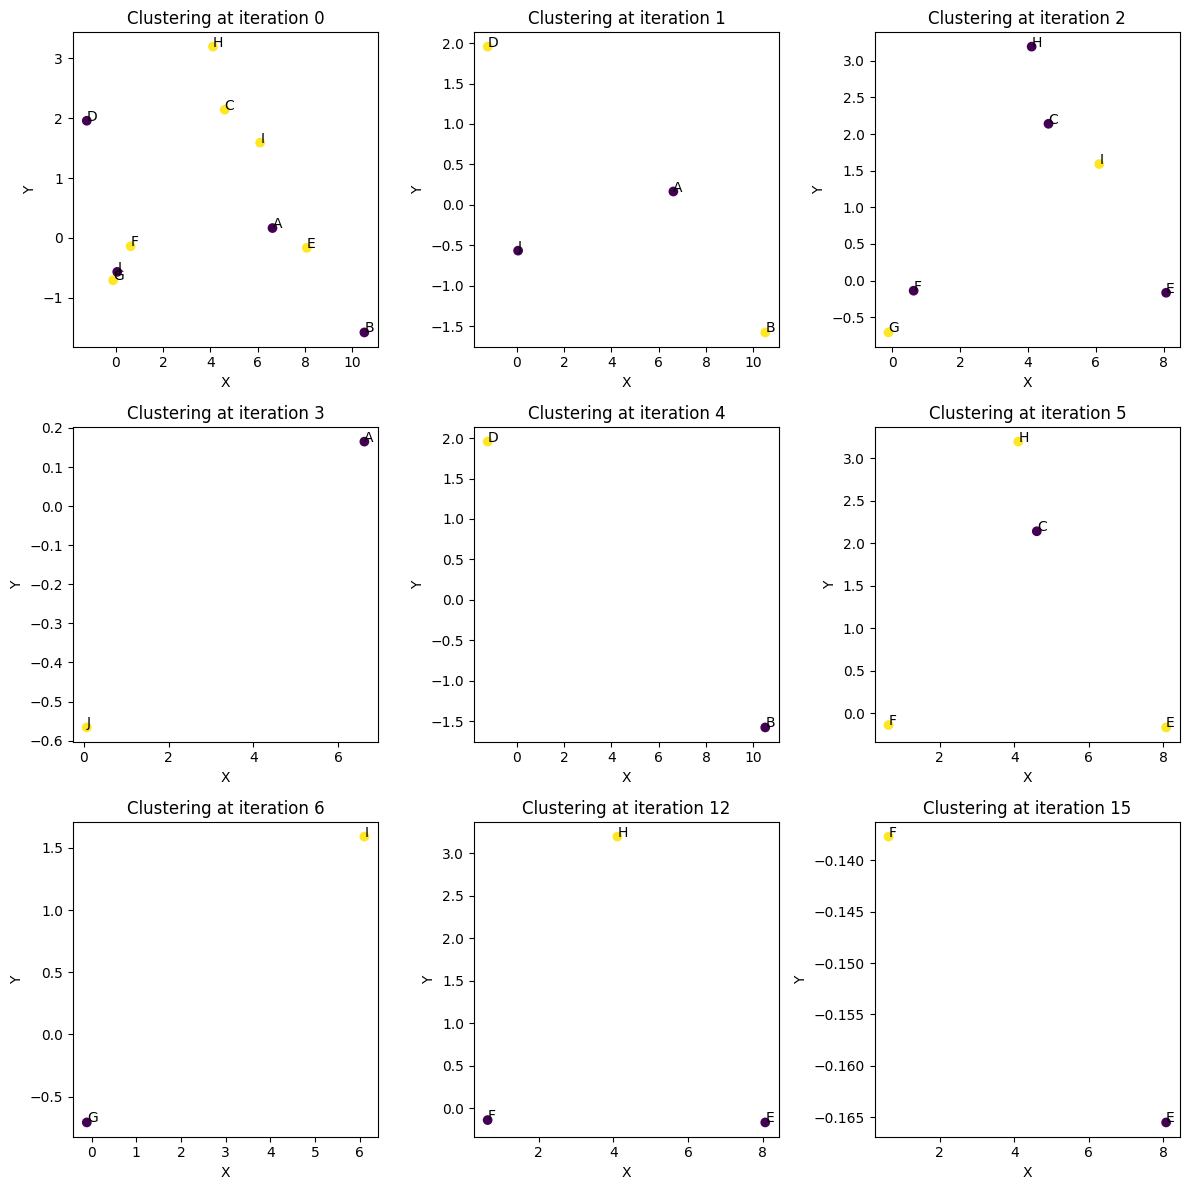

In [21]:
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_MaxCut, coreset_df)

## Visualizing the cost output

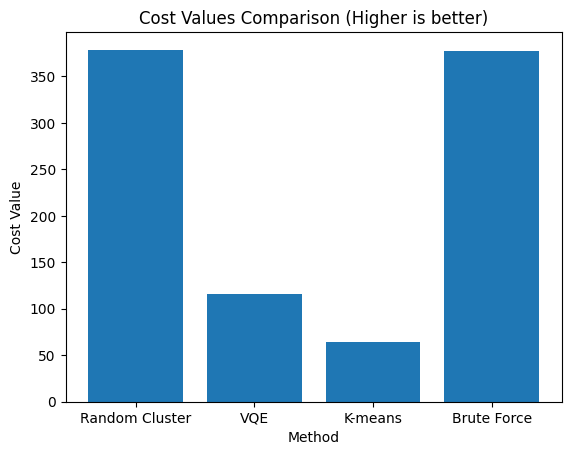

In [20]:
# Define the cost values
cost_values = [random_cost, VQE_cost, KMeans_cost, MaxCut_cost]

# Define the labels for the x-axis
labels = ['Random Cluster','VQE', 'K-means', 'Brute Force']

# Create the bar chart
plt.bar(labels, cost_values)

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Cost Value')
plt.title('Cost Values Comparison (Higher is better)')

# Display the chart
plt.show()